In [107]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, tensorflow as tf, os
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers as tfl, optimizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image 
import cv2
import sys
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model

#np.set_printoptions(threshold=sys.maxsize)

In [108]:
data = []
labels =[]
import glob
galaxy_path = glob.glob('./Cutout Files/galaxy/*')
star_path = glob.glob('./Cutout Files/star/*')
for x in galaxy_path:
    image = cv2.imread(x,1)
    image= np.array(image)
    data.append(image)
    labels.append(0)
for x in star_path:
    image = cv2.imread(x,1)
    image= np.array(image)
    data.append(image)
    labels.append(1)  

In [109]:
data, labels= np.array(data), np.array(labels)


In [110]:
dataset= pd.DataFrame(list(zip(data, labels)), columns=['images','labels'])

In [111]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2,
                                                random_state=42, shuffle=True,stratify=dataset['labels'].values)

x_test, x_valid, y_test, y_valid= train_test_split(x_test, y_test, test_size=0.5,
                                                random_state=42, shuffle=True)

In [112]:
y_train, y_valid = to_categorical(y_train),  to_categorical(y_valid)

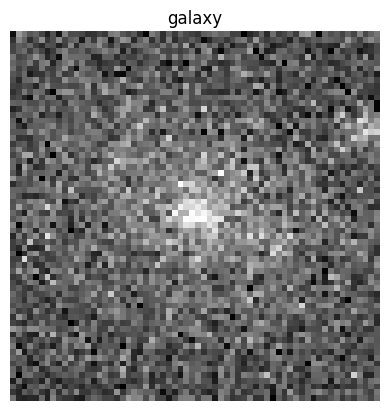

In [113]:
def show_img(x, y, index):
    plt.imshow(x[index])
    if y[index]==0:
        plt.title('galaxy')
    else:
        plt.title('star')
    plt.axis('off')    
    plt.show()    

show_img(x_test, y_test, 42)

In [114]:
def identity_block(input_img, filters):
    x_img= input_img
    
    #layer 1
    conv11 = tfl.Conv2D(filters, kernel_size=3, padding='same')(x_img)
    batch11 = tfl.BatchNormalization()(conv11)
    act11 = tfl.Activation('relu')(batch11)
    
    #layer 2
    conv21 = tfl.Conv2D(filters, kernel_size= 3, padding='same')(act11)
    batch21 = tfl.BatchNormalization()(conv21)
    
    # adding layers
    x_add = tfl.Add()([x_img, batch21])
    x_identity = tfl.Activation('relu')(x_add)
    
    return x_identity

In [115]:
def conv_block(input_img, filters):
    x_img = input_img
    
    #layer 1
    conv11 = tfl.Conv2D( filters, kernel_size=3, padding='same', strides=2)(x_img)
    batch11 = tfl.BatchNormalization()(conv11)
    act11 = tfl.Activation('relu')(batch11)
    
    #layer 2
    conv21 = tfl.Conv2D( filters, kernel_size= 3, padding='same')(act11)
    batch21 = tfl.BatchNormalization()(conv21)
    
    #conv block layer
    conv_blk = tfl.Conv2D( filters, kernel_size= 1, strides=2)(x_img)
    
    # adding layers
    x_add = tfl.Add()([batch21, conv_blk])
    x_conv = tfl.Activation('relu')(x_add)
    
    return x_conv

In [116]:
def resnet_model(classes, shape=(256,256,3)):
    
    x= tfl.Input(shape)
    x_rescaled = tfl.Rescaling(scale=1./255)(x)
    #base layer
    c1= tfl.Conv2D(64, kernel_size=7, strides=2, padding='same')(x_rescaled)
    b1= tfl.BatchNormalization()(c1)
    a1= tfl.Activation('relu')(b1)
    pool1= tfl.MaxPool2D(strides=(2,2), pool_size=3)(a1)
    
    # 1st identity block
    iden_layer1 = identity_block(pool1, 64)
    iden_layer2 = identity_block(iden_layer1, 64)
    iden_layer3 = identity_block(iden_layer2, 64)
    
    # 1st convolutional block
    conv_layer1 = conv_block(iden_layer3, 128)
    
    # 2nd identity block
    iden_layer1 = identity_block(conv_layer1, 128)
    iden_layer2 = identity_block(iden_layer1, 128)
    iden_layer3 = identity_block(iden_layer2, 128)
    
    # 2nd convolutional block
    conv_layer1 = conv_block(iden_layer3, 256)
    
    # 3rd identity block
    iden_layer1 = identity_block(conv_layer1, 256)
    iden_layer2 = identity_block(iden_layer1, 256)
    iden_layer3 = identity_block(iden_layer2, 256)
    iden_layer4 = identity_block(iden_layer3, 256)
    iden_layer5 = identity_block(iden_layer4, 256)
    
    # 3rd convolutional block
    conv_layer1 = conv_block(iden_layer5, 512)
    
    # 4th identity block
    iden_layer1 = identity_block(conv_layer1, 512)
    iden_layer2 = identity_block(iden_layer1, 512)
    
    # final layer
    
    avg_pool = tfl.AveragePooling2D((2,2), padding='same' )(iden_layer2)
    flat = tfl.Flatten()(avg_pool)
    d1 = tfl.Dense(1024, activation = 'relu')(flat)
    d2 = tfl.Dense(classes, activation='softmax')(d1) 
    model = tf.keras.models.Model(inputs= x, outputs= d2, name='RESNET34_ARCH')
    
    return model

In [117]:
model = resnet_model(2,(64,64,3))

In [118]:
model.summary()

Model: "RESNET34_ARCH"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 rescaling_3 (Rescaling)        (None, 64, 64, 3)    0           ['input_4[0][0]']                
                                                                                                  
 conv2d_108 (Conv2D)            (None, 32, 32, 64)   9472        ['rescaling_3[0][0]']            
                                                                                                  
 batch_normalization_99 (BatchN  (None, 32, 32, 64)  256         ['conv2d_108[0][0]']             
 ormalization)                                                                        

In [119]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [120]:
import keras

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [121]:
model.compile(optimizer= optimizers.Adam(learning_rate=0.01),
             loss='categorical_crossentropy',
                    metrics=METRICS)

In [122]:
import os
paths = {'model_path' : os.path.join('models'), 
         'weights_path' : os.path.join('models','weights'),
         'saved_model_path' : os.path.join('models', 'saved_model'),
         'checkpoint_path' : os.path.join('models','checkpoints')
        }

In [123]:
for key, value in paths.items():
    if not os.path.exists(value):
        !mkdir {value}

In [124]:
# simple early stopping
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
model_ckpt= ModelCheckpoint(
                        paths['checkpoint_path'], monitor='val_auc', verbose=0, save_best_only=True,
                         mode='max', save_freq='epoch')

from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_auc', factor=0.2,
                              patience=4, min_lr=0.001)

es = EarlyStopping(monitor='val_prc', mode='auto', verbose=1,
                  restore_best_weights=True)

In [125]:
history_resnet = model.fit(x_train, y_train,
                           validation_data=(x_valid, y_valid),
                    epochs=10,      
                    verbose=1,
                    batch_size=128,
                          callbacks=[model_ckpt,reduce_lr])

Epoch 1/10
25/25 [==============================] - ETA: 0s - loss: 6.9818 - tp: 2316.0000 - fp: 872.0000 - tn: 2316.0000 - fn: 872.0000 - accuracy: 0.7265 - precision: 0.7265 - recall: 0.7265 - auc: 0.7478 - prc: 0.7280

INFO:tensorflow:Assets written to: models\checkpoints\assets


INFO:tensorflow:Assets written to: models\checkpoints\assets


25/25 [==============================] - 189s 7s/step - loss: 6.9818 - tp: 2316.0000 - fp: 872.0000 - tn: 2316.0000 - fn: 872.0000 - accuracy: 0.7265 - precision: 0.7265 - recall: 0.7265 - auc: 0.7478 - prc: 0.7280 - val_loss: 106542481408.0000 - val_tp: 301.0000 - val_fp: 98.0000 - val_tn: 301.0000 - val_fn: 98.0000 - val_accuracy: 0.7544 - val_precision: 0.7544 - val_recall: 0.7544 - val_auc: 0.7544 - val_prc: 0.7160 - lr: 0.0100
Epoch 2/10
25/25 [==============================] - 179s 7s/step - loss: 0.5595 - tp: 2430.0000 - fp: 758.0000 - tn: 2430.0000 - fn: 758.0000 - accuracy: 0.7622 - precision: 0.7622 - recall: 0.7622 - auc: 0.8221 - prc: 0.8176 - val_loss: 321911.4062 - val_tp: 301.0000 - val_fp: 98.0000 - val_tn: 301.0000 - val_fn: 98.0000 - val_accuracy: 0.7544 - val_precision: 0.7544 - val_recall: 0.7544 - val_auc: 0.7544 - val_prc: 0.7160 - lr: 0.0100
Epoch 3/10
25/25 [==============================] - ETA: 0s - loss: 0.4553 - tp: 2435.0000 - fp: 753.0000 - tn: 2435.0000 -

INFO:tensorflow:Assets written to: models\checkpoints\assets


INFO:tensorflow:Assets written to: models\checkpoints\assets


25/25 [==============================] - 213s 9s/step - loss: 0.4553 - tp: 2435.0000 - fp: 753.0000 - tn: 2435.0000 - fn: 753.0000 - accuracy: 0.7638 - precision: 0.7638 - recall: 0.7638 - auc: 0.8653 - prc: 0.8668 - val_loss: 456.4921 - val_tp: 301.0000 - val_fp: 98.0000 - val_tn: 301.0000 - val_fn: 98.0000 - val_accuracy: 0.7544 - val_precision: 0.7544 - val_recall: 0.7544 - val_auc: 0.7815 - val_prc: 0.7459 - lr: 0.0100
Epoch 4/10
25/25 [==============================] - 194s 8s/step - loss: 0.4058 - tp: 2504.0000 - fp: 684.0000 - tn: 2504.0000 - fn: 684.0000 - accuracy: 0.7854 - precision: 0.7854 - recall: 0.7854 - auc: 0.8914 - prc: 0.8951 - val_loss: 2.6419 - val_tp: 265.0000 - val_fp: 134.0000 - val_tn: 265.0000 - val_fn: 134.0000 - val_accuracy: 0.6642 - val_precision: 0.6642 - val_recall: 0.6642 - val_auc: 0.7604 - val_prc: 0.7358 - lr: 0.0100
Epoch 5/10
25/25 [==============================] - ETA: 0s - loss: 0.3710 - tp: 2637.0000 - fp: 551.0000 - tn: 2637.0000 - fn: 551.000

INFO:tensorflow:Assets written to: models\checkpoints\assets


INFO:tensorflow:Assets written to: models\checkpoints\assets


25/25 [==============================] - 213s 9s/step - loss: 0.3710 - tp: 2637.0000 - fp: 551.0000 - tn: 2637.0000 - fn: 551.0000 - accuracy: 0.8272 - precision: 0.8272 - recall: 0.8272 - auc: 0.9147 - prc: 0.9169 - val_loss: 43.9035 - val_tp: 287.0000 - val_fp: 112.0000 - val_tn: 287.0000 - val_fn: 112.0000 - val_accuracy: 0.7193 - val_precision: 0.7193 - val_recall: 0.7193 - val_auc: 0.7856 - val_prc: 0.7546 - lr: 0.0100
Epoch 6/10
25/25 [==============================] - 198s 8s/step - loss: 0.3574 - tp: 2661.0000 - fp: 527.0000 - tn: 2661.0000 - fn: 527.0000 - accuracy: 0.8347 - precision: 0.8347 - recall: 0.8347 - auc: 0.9210 - prc: 0.9239 - val_loss: 4.7908 - val_tp: 260.0000 - val_fp: 139.0000 - val_tn: 260.0000 - val_fn: 139.0000 - val_accuracy: 0.6516 - val_precision: 0.6516 - val_recall: 0.6516 - val_auc: 0.7584 - val_prc: 0.7451 - lr: 0.0020
Epoch 7/10
25/25 [==============================] - 185s 7s/step - loss: 0.3241 - tp: 2724.0000 - fp: 464.0000 - tn: 2724.0000 - fn: 4

In [126]:
training_score= history_resnet.history

Text(0.5, 1.0, 'Loss Function')

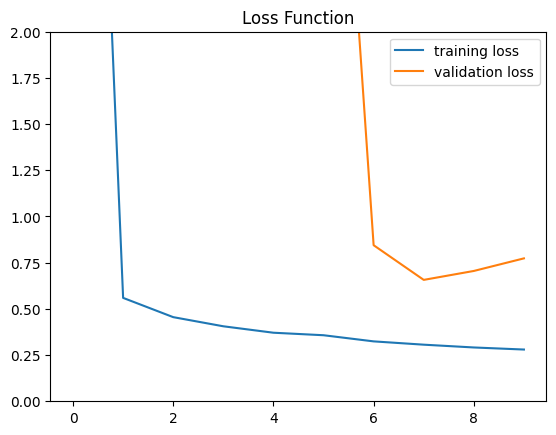

In [127]:
plt.plot(training_score['loss'], label='training loss')
plt.plot(training_score['val_loss'], label='validation loss')
plt.ylim(0,2)
plt.legend()
plt.title('Loss Function')

Text(0.5, 1.0, 'AUC Function')

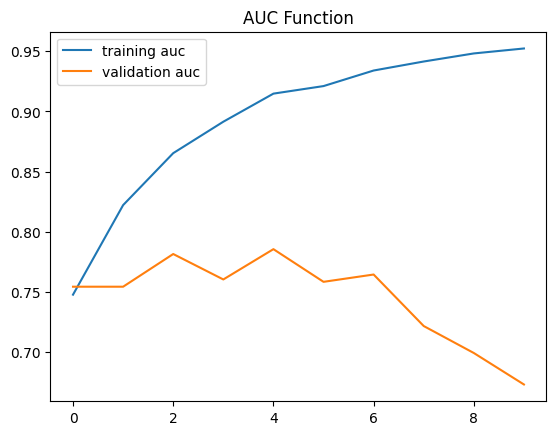

In [128]:
plt.plot(training_score['auc'], label='training auc')
plt.plot(training_score['val_auc'], label='validation auc')
plt.legend()
plt.title('AUC Function')

Text(0.5, 1.0, 'Precision Function')

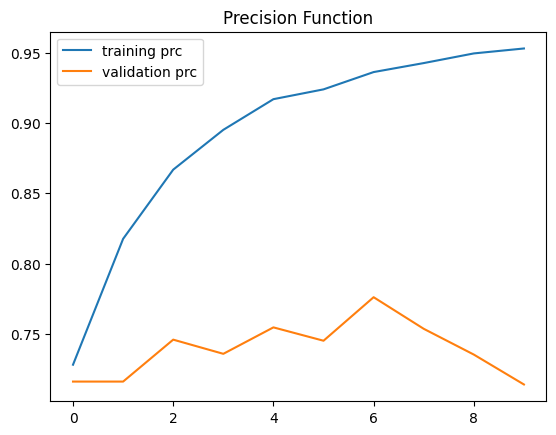

In [129]:
plt.plot(training_score['prc'], label='training prc')
plt.plot(training_score['val_prc'], label='validation prc')
plt.legend()
plt.title('Precision Function')

In [130]:
model_name= 'resent_star_galaxy.h5'
model.save(paths['saved_model_path'] + model_name)

In [131]:
from sklearn.metrics import roc_curve, auc


In [132]:
loaded_saved_model= keras.models.load_model(paths['saved_model_path']+model_name)
loaded_saved_ckpt= keras.models.load_model(paths['checkpoint_path'])

In [133]:
def evaluate_results(x,y, classes):
    predicted_prob = loaded_saved_ckpt.predict(x)
    fpr= {}
    tpr ={}
    threshold_ ={}
    auc_ ={}
    for i in range(classes):
        fpr[i], tpr[i], threshold_[i]= roc_curve(y, predicted_prob[:,i], pos_label=i)
        auc_[i] = auc(fpr[i], tpr[i])      
    
    return fpr, tpr, threshold_, auc_    
num_classes= 2
fpr, tpr, threshold_, auc_score= evaluate_results(x_test,y_test, num_classes)

13/13 [==============================] - 5s 336ms/step


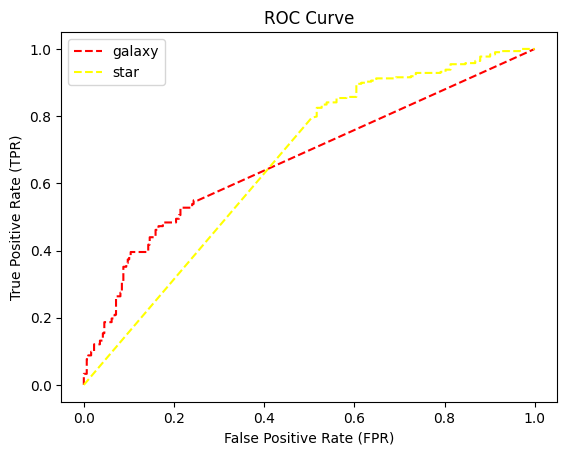

********** 
 AUC score for class GALAXY:  0.6683673469387754 
 ********** 
 AUC score for class STAR:  0.6586092478949622 
 **********


In [134]:
plt.plot(fpr[0],tpr[0], linestyle='--',color='red', label='galaxy')
plt.plot(fpr[1],tpr[1], linestyle='--',color='yellow', label='star')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='best')
plt.show()
print('*'*10,'\n','AUC score for class GALAXY: ', auc_score[0], '\n', '*'*10,'\n', 'AUC score for class STAR: ', auc_score[1], '\n', '*'*10)